In [1]:
import random as rd, numpy as np, torch as trc
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

trc.random.manual_seed(0)
np.random.seed(0)
rd.seed(0)

plt.style.use('dark_background')

# Data review & preparation

In [2]:
with open('names.txt') as f:
    data = f.read().split('\n')[:-1]

data[:5], len(data)

(['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin'], 9408)

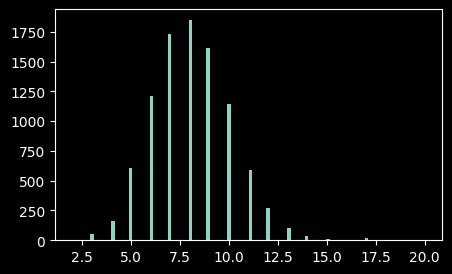

In [3]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (5, 3)
plt.hist(list(map(len, data)), bins=100);

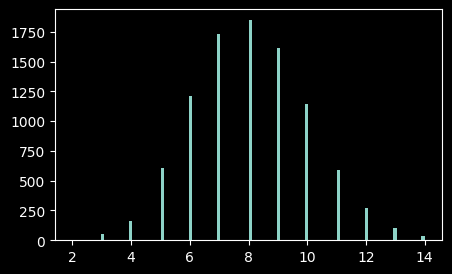

In [4]:
data = [i for i in data if len(i) <= 14]
plt.hist(list(map(len, data)), bins=100);

In [5]:
data[:5], len(data)

(['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin'], 9368)

In [19]:
tokens = sorted(list(set(''.join(data))))
token2id = {t: i+1 for i, t in enumerate(tokens)}
token2id[' '] = 0 # add special symbol (space) with indx=0 for no prefix gen
[(k, token2id[k]) for k in list(token2id)[:5]]

[("'", 1), (',', 2), ('-', 3), ('A', 4), ('B', 5)]

При формировании векторного представления данных, в начале каждого элемента оставляем нулевое значение (необходимо для возможности генерации слов без заданного префикса).

In [20]:
data_vec = np.zeros((len(data), max(map(len, data))+1), dtype='int32')
for i in range(len(data_vec)):
    ids = [token2id[t] for t in data[i]]
    data_vec[i, 1:len(ids)+1] = ids 
data_vec[:5]

array([[ 0,  4, 28, 27, 28, 37, 41,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4, 28, 27, 31, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4, 28, 27, 33, 49, 27, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4, 28, 27, 35, 30, 46, 38, 35, 40,  0,  0,  0,  0,  0],
       [ 0,  4, 28, 27, 35, 30, 46, 38, 38, 35, 40,  0,  0,  0,  0]])

# Neural Net Architecture

Зачем использовать "embedding"?
- получаем контроль над размерностью вектора для представления одного символа;
- избавляемся от нерелевантной (скорее всего) иерархии между буквами;
- <b>самое главное:</b> веса модуля Embedding, использующиеся для получения векторных представлений индексов, настраиваются при обучении модели. Таким образом, каждый символ наделяется релевантными (скорее всего) признаками.

In [21]:
# Vanila RNN (this one eqivalent to trc.nn.RNN, there's also trc.nn.LSTM, trc.nn.GRU etc.)
class RNN_V(trc.nn.Module):
    def __init__(self, alphabet_size, emb_size=8, h_size=32):
        super().__init__()
        self.h_size = h_size
        self.embed = trc.nn.Embedding(alphabet_size, emb_size)

        self.fc_update_h = trc.nn.Linear(emb_size+h_size, h_size)
        self.fc_res = trc.nn.Linear(h_size, alphabet_size)

        self.act = trc.nn.Tanh()
    
    # vanila recurrent step, any other architecture can be used here (this one equivalent to trc.nn.RNNCell)
    def step(self, x, h):
        x = self.embed(x)
        x_and_h = trc.cat([x, h], dim=-1) # concatenate input (emb) and h for each item
        h = self.act(self.fc_update_h(x_and_h)) # update H
        return self.fc_res(h), h # return step OUT and all hidden states (1 h here)
    
    def forward(self, x):
        h, res = trc.zeros([len(x), self.h_size], dtype=trc.float32), []
        # recurrent actions (steps) for each ITEM in a SEQUENCE:
        for i in range(x.shape[1]):
            out, h = self.step(x[:, i], h) # get batch of indxs for ITEM i and make a STEP
            res.append(out) # save output after each step
        
        # using "stack" to concatenate along the new dimension (in order to stack results for each recurrent step)
        # transpose for CE loss which requires dims as follows — (batch, classes, ...)
        return trc.stack(res, dim=1).transpose(1, 2), h # return last h in case if consequent generation is needed

# Neural Net Training

In [22]:
net = RNN_V(alphabet_size=len(token2id), emb_size=8, h_size=32)
loss = trc.nn.CrossEntropyLoss()
optimizer = trc.optim.Adam(net.parameters(), lr=0.001)

In [23]:
epochs_n, batch_size = 3, 32
x, idxs = trc.tensor(data_vec, dtype=trc.long), list(range(len(data_vec)))
acc_hist, loss_hist = [], []

for i in tqdm(range(epochs_n)):
    rd.shuffle(idxs) # trying to avoid using torch data loaders
    for j in range(0, len(data_vec), batch_size):
        batch_idxs = idxs[j:j+batch_size]
        batch = x[batch_idxs]
        preds, _ = net(batch[:, :-1]) # no predictions for last symbols (:-1)
        loss_val = loss(preds, batch[:, 1:]) # cosequent symbols are targets (1:)

        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()

        acc_hist.append((preds.argmax(1) == batch[:, 1:]).float().mean())
        loss_hist.append(loss_val.data)

100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


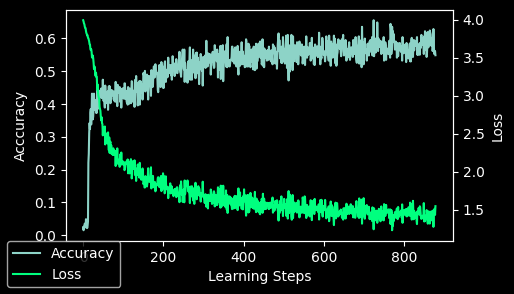

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(acc_hist, label='Accuracy')
ax2.plot(loss_hist, c='springgreen', label='Loss')
ax1.set_xlabel('Learning Steps')
ax1.set_ylabel('Acccuracy')
ax2.set_ylabel('Loss')
fig.legend(loc='lower left');

# Testing

In [41]:
# in order to convert predicted indxs to symbols
id2token = {token2id[t]: t for t in token2id}
[(k, id2token[k]) for k in list(id2token)[:5]]

[(1, "'"), (2, ','), (3, '-'), (4, 'A'), (5, 'B')]

In [100]:
def generate_sample(net, prefix=' ', max_len=14, temperature=1):
    x = trc.tensor([token2id[i] for i in prefix], dtype=trc.long).unsqueeze(0)
    res, h = net(x)

    # use temperature to increase or decrease the difference between values
    next_probs = F.softmax(res[:, :, -1].squeeze()/temperature, dim=0).detach().numpy()
    # using softmax output as probs for choosing next indx
    next_char = np.random.choice(range(len(token2id)), p=next_probs)
    x = trc.cat([x, trc.tensor([[next_char]])], dim=1)

    for i in range(len(prefix), max_len):
        out, h = net.step(x[:, i], h)

        # error without numpy(), bug
        next_probs = F.softmax(out.squeeze()/temperature, dim=0).detach().numpy()
        next_char = np.random.choice(range(len(token2id)), p=next_probs)
        x = trc.cat([x, trc.tensor([[next_char]])], dim=1)

    return ''.join([id2token[int(i)] for i in x[0, 1:]])

In [101]:
for i in range(10):
    print(generate_sample(net, temperature=0.5))

Vulenov       
Eairinov      
Abatinov      
Parolov       
Rakain        
Abarudov      
Abaranov      
Jashanov      
Zhalyaev      
Henkov        


In [97]:
for i in range(10):
    print(generate_sample(net, prefix=' Bal', temperature=0.5))

Balinsky      
Balarov       
Balukin       
Balov         
Balun         
Balov         
Balrinov      
Balymin       
Balaumov      
Balsshan      
